# Лабораторная работа №3 по курсу "Интеллектуальный анализ данных".

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("darkgrid")

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import warnings
import sys  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [72]:
anime = 'data/anime.csv'
rating = 'data/rating.csv'
data = pd.read_csv(anime)

In [73]:
data.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


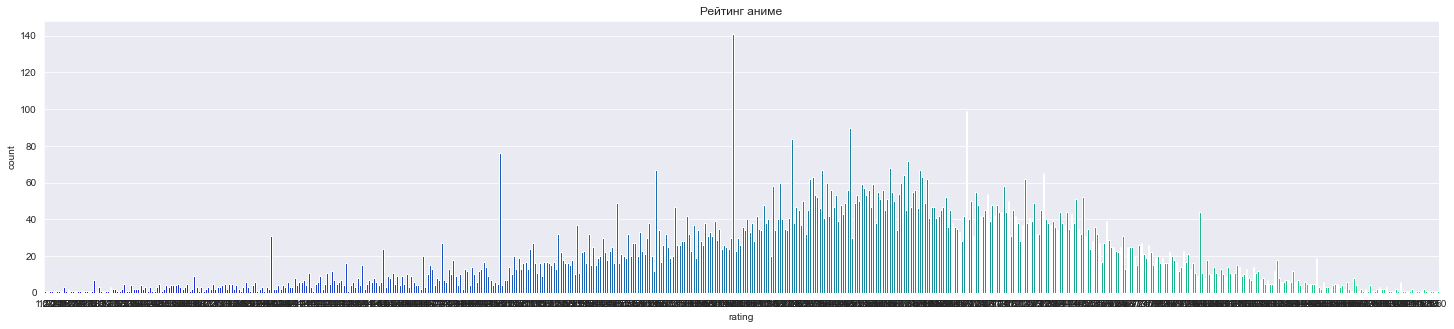

In [74]:
fig, ax = plt.subplots(figsize=(25,5))
sns.countplot(data['rating'], palette='winter')
ax.set(title='Рейтинг аниме')
plt.show()

#### Проверка пропущенных значений.

In [75]:
data.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

#### Заполним пропущенные значения.

In [76]:
data.genre = data.genre.fillna("None")
data.type = data.type.fillna("None")
data.rating = data.rating.fillna(data.rating.mean())

#### Контрольная проверка пропущенных значений.

In [77]:
data.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

#### Посмотрим корреляцию между признаками:

In [87]:
data_new = pd.read_csv(anime)
data_new.pop('name')
data_new.pop('genre')
data_new.pop('type')
data_new.rating = data.rating.fillna(data.rating.mean())
#data_new["new_episodes"] = pd.to_numeric(data_new["episodes"].astype(str).str.replace(r"[^\d\-]", ""), errors="coerce")
#data_new["new_members"] = pd.to_numeric(data_new["members"].astype(str).str.replace(r"[^\d\-]", ""), errors="coerce")
data_new = pd.DataFrame.from_dict(data_new)
pd.DataFrame([data_new.columns, data.dtypes], index=['Column Name', 'Column Type']).T
#data_new['new_members'] = data_new['new_members'].astype('new_episodes').cat.codes

,Column Name,Column Type
0,anime_id,int64
1,episodes,object
2,rating,float64
3,members,int64


In [88]:
data_new.head(10)

,anime_id,episodes,rating,members
0,32281,1,9.37,200630
1,5114,64,9.26,793665
2,28977,51,9.25,114262
3,9253,24,9.17,673572
4,9969,51,9.16,151266
5,32935,10,9.15,93351
6,11061,148,9.13,425855
7,820,110,9.11,80679
8,15335,1,9.10,72534
9,15417,13,9.11,81109


In [89]:
data_new.isna().sum()

anime_id    0
episodes    0
rating      0
members     0
dtype: int64

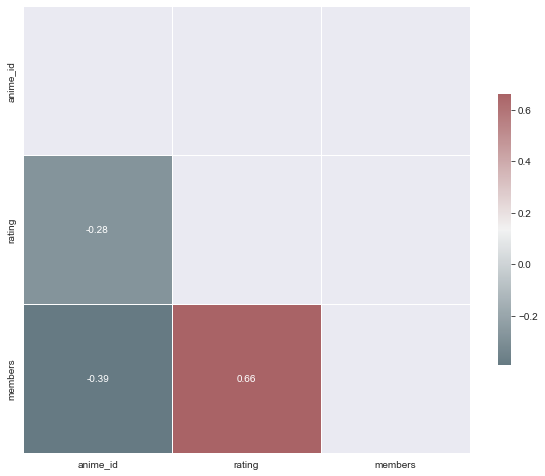

In [90]:
corr = data_new.corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, 30, as_cmap=True)
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True)
plt.show()

### Описание функций для поиска гиперпараметров и вывода результатов.

In [91]:
# параметры для дерева решений
params = dict(max_depth = np.linspace(1, 32, 32, endpoint=True), 
                      min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True),
                      min_samples_leaf = np.linspace(0.01, 0.1, 10, endpoint=True)
                      )

# поиск лучших гиперпараметров
def do_grid_search(model,params, x_train, y_train, x_test, refit='accuracy'):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    grid_search = GridSearchCV(model, params, scoring=['accuracy'], 
                                n_jobs=4, cv=cv, verbose=3, refit=refit) 
    grid_search.fit(x_train.values, y_train.values)
    y_pred = grid_search.predict(x_test.values)
    print('Best params for {}'.format(refit))
    print(grid_search.best_params_)

# вывод результата
def print_result(y_test, pred=None):
  print("результат классификации: \n", classification_report(y_test, pred))
  conf_matrix = confusion_matrix(y_test, pred)
  print("Матрица ошибок: \n", conf_matrix, "\n")
  sns.heatmap(conf_matrix, cmap = cmap, annot=True)
  plt.show()

### Разделение данных на обучающую и тестовую выборки.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(data_new.drop('episodes',axis=1), data_new['episodes'], test_size=0.6, random_state=42)

### Классификация без настройки гиперпараметров

результат классификации: 
               precision    recall  f1-score   support

           1       0.58      0.53      0.56      3457
          10       0.02      0.03      0.03        71
         100       0.00      0.00      0.00         7
         101       0.00      0.00      0.00         3
         102       0.00      0.00      0.00         2
         103       0.00      0.00      0.00         3
         104       0.00      0.00      0.00         9
         105       0.00      0.00      0.00         3
         108       0.00      0.00      0.00         1
         109       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        46
         110       0.00      0.00      0.00         1
         112       0.00      0.00      0.00         2
         113       0.00      0.00      0.00         0
         114       0.00      0.00      0.00         2
         115       0.00      0.00      0.00         1
         117       0.00      0.00      0.00         1


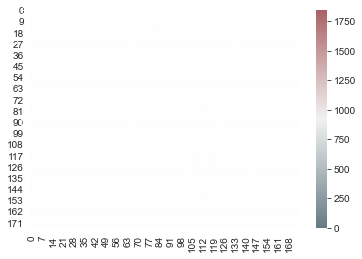

Средняя точность без настройки гиперпараметров:  0.2975384379988256


In [93]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print_result(y_test=y_test, pred=predictions)
score = cross_val_score(dtree, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность без настройки гиперпараметров: ', np.mean(score))

Точность низковата, предположим что настройка гиперпараметров даст улучшение.

### Классификация с настройкой гиперпараметров

In [94]:
do_grid_search(model=dtree,  params=params, x_train=X_train, y_train=y_train, x_test=X_test)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits
Best params for accuracy
{'max_depth': 3.0, 'min_samples_leaf': 0.030000000000000006, 'min_samples_split': 0.01}


результат классификации: 
               precision    recall  f1-score   support

           1       0.50      0.97      0.66      3457
          10       0.00      0.00      0.00        71
         100       0.00      0.00      0.00         7
         101       0.00      0.00      0.00         3
         102       0.00      0.00      0.00         2
         103       0.00      0.00      0.00         3
         104       0.00      0.00      0.00         9
         105       0.00      0.00      0.00         3
         108       0.00      0.00      0.00         1
         109       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        46
         110       0.00      0.00      0.00         1
         112       0.00      0.00      0.00         2
         114       0.00      0.00      0.00         2
         115       0.00      0.00      0.00         1
         117       0.00      0.00      0.00         1
         119       0.00      0.00      0.00         1


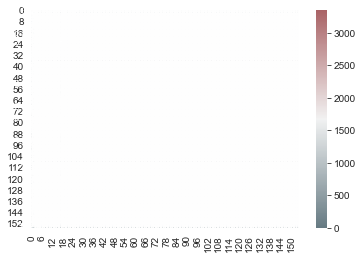

Средняя точность с настройкой гиперпараметров GridSearch:  0.4594260973128551


In [95]:
dtree_grid = DecisionTreeClassifier(random_state=42, max_depth=4.0, min_samples_leaf=0.01, min_samples_split=0.01)

print_result(y_test=y_test, pred=dtree_grid.fit(X_train, y_train).predict(X_test))
score = cross_val_score(dtree_grid, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность с настройкой гиперпараметров GridSearch: ', np.mean(score))

### Оценка точности классификаций тестовой и обучающей выборок.

In [96]:
from sklearn.metrics import accuracy_score

max_depth = np.linspace(1, 32, 32, endpoint=True)
accuracy_result = []
cv_result = []
for md in max_depth:
  model = DecisionTreeClassifier(random_state=42, max_depth=md)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_test)
  accuracy_result.append(accuracy_score(y_test, model_pred))
  scores = cross_val_score(model, X_train, y_train, cv=5)
  cv_result.append(np.mean(scores))

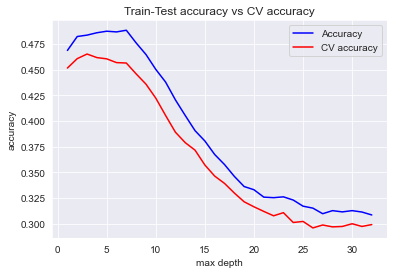

In [97]:
plt.plot(max_depth, accuracy_result, color='b', label='Accuracy')
plt.plot(max_depth, cv_result, color='r', label='CV accuracy')
plt.title('Train-Test accuracy vs CV accuracy')
plt.xlabel('max depth'); plt.ylabel('accuracy')
plt.legend()
plt.show()

In [98]:
accuracy_result_train, accuracy_result_test = [],[]
for md in max_depth:
  model = DecisionTreeClassifier(random_state=42, max_depth=md)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_train)
  accuracy_result_train.append(accuracy_score(y_train, model_pred))

  model.fit(X_test ,y_test)
  model_pred = model.predict(X_test)
  accuracy_result_test.append(accuracy_score(y_test, model_pred))

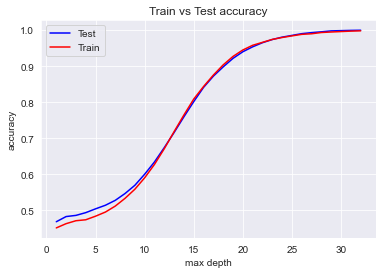

In [99]:
plt.plot(max_depth, accuracy_result_test, color='b', label='Test')
plt.plot(max_depth, accuracy_result_train, color='r', label='Train')
plt.title('Train vs Test accuracy')
plt.xlabel('max depth'); plt.ylabel('accuracy')
plt.legend()
plt.show()

### Классификация с использованием масштабирования признаков

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

результат классификации: 
               precision    recall  f1-score   support

           1       0.58      0.53      0.56      3457
          10       0.02      0.03      0.03        71
         100       0.00      0.00      0.00         7
         101       0.00      0.00      0.00         3
         102       0.00      0.00      0.00         2
         103       0.00      0.00      0.00         3
         104       0.00      0.00      0.00         9
         105       0.00      0.00      0.00         3
         108       0.00      0.00      0.00         1
         109       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        46
         110       0.00      0.00      0.00         1
         112       0.00      0.00      0.00         2
         113       0.00      0.00      0.00         0
         114       0.00      0.00      0.00         2
         115       0.00      0.00      0.00         1
         117       0.00      0.00      0.00         1


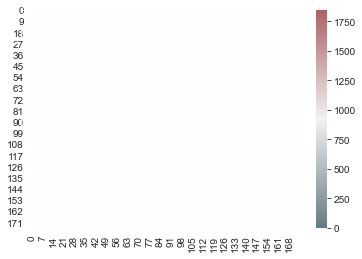

Средняя точность с масштабируемыми признаками:  0.29692888866833733


In [101]:
dtree_scaled = DecisionTreeClassifier(random_state=42)

print_result(y_test=y_test, pred=dtree_scaled.fit(X_train_scaled, y_train).predict(X_test_scaled))
score = cross_val_score(dtree_scaled, X_train_scaled, y_train, cv=5, scoring='accuracy')
print('Средняя точность с масштабируемыми признаками: ', np.mean(score))

## Этап 2. Бинарная классификация.

### Загрузка данных.

In [120]:
anime_data = pd.read_csv(anime)

### Посмотрим на полученные данные.

In [121]:
anime_data

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


#### Удаление полей, которые невозможно бинаризировать.

In [122]:
anime_data.drop('name', axis=1, inplace=True)
anime_data.drop('genre', axis=1, inplace=True)
anime_data.drop('type', axis=1, inplace=True)
anime_data.drop('episodes', axis=1, inplace=True)

#### Бинаризация полей

In [123]:
anime_data.loc[(anime_data.rating<=5),'rating']=0
anime_data.loc[(anime_data.rating>5),'rating']=1
anime_data.loc[(anime_data.members<=5000),'members']=0
anime_data.loc[(anime_data.members>5000),'members']=1
target = anime_data.members
features = anime_data.drop(['rating'], axis=1)

### Разделение данных на выборки.

In [124]:
anime_data

,anime_id,rating,members
0,32281,1.0,1
1,5114,1.0,1
2,28977,1.0,1
3,9253,1.0,1
4,9969,1.0,1
...,...,...,...
12289,9316,0.0,0
12290,5543,0.0,0
12291,5621,0.0,0
12292,6133,0.0,0


In [125]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, shuffle=True)

### Классификация без настройки параметров.

результат классификации: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2469
           1       1.00      1.00      1.00      1220

    accuracy                           1.00      3689
   macro avg       1.00      1.00      1.00      3689
weighted avg       1.00      1.00      1.00      3689

Матрица ошибок: 
 [[2469    0]
 [   0 1220]] 



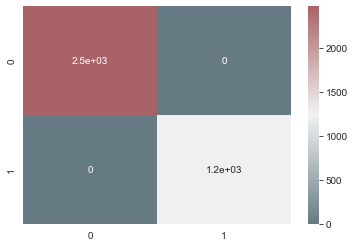

In [126]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42, solver='newton-cg')
lr.fit(X_train ,y_train)
lr_pred = lr.predict(X_test)

print_result(y_test=y_test, pred=lr_pred)

#### Оценка точности

In [127]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_train, y_train, cv=5)
print('Средняя оценка точности: ', np.mean(scores))

Средняя оценка точности:  1.0


### Классификация c настройкой параметров.

In [128]:
from sklearn.metrics import accuracy_score

penalties = ['l2', 'none']
accuracy_result = []
cv_result = []
for penalty in penalties:
  # для 'newton-cg' возможно испльзование только 'l2' или 'none' в качестве параметров
  model = LogisticRegression(random_state=42, solver='newton-cg', penalty=penalty)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_test)
  accuracy_result.append(accuracy_score(y_test, model_pred))
  scores = cross_val_score(model, X_train, y_train, cv=5)
  cv_result.append(np.mean(scores))

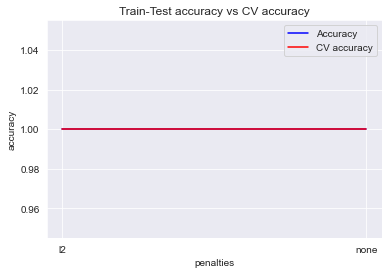

In [129]:
plt.plot(penalties, accuracy_result, color='b', label='Accuracy')
plt.plot(penalties, cv_result, color='r', label='CV accuracy')
plt.title('Train-Test accuracy vs CV accuracy')
plt.legend()
plt.xlabel('penalties'); plt.ylabel('accuracy')
plt.show()

Точность по оценке train-test без регуляризации даёт лучший результат.

In [130]:
accuracy_result_train, accuracy_result_test = [],[]
for penalty in penalties:
  model = LogisticRegression(random_state=42, solver='newton-cg', penalty=penalty)
  model.fit(X_train ,y_train)
  model_pred = model.predict(X_train)
  accuracy_result_train.append(accuracy_score(y_train, model_pred))

  model.fit(X_test ,y_test)
  model_pred = model.predict(X_test)
  accuracy_result_test.append(accuracy_score(y_test, model_pred))

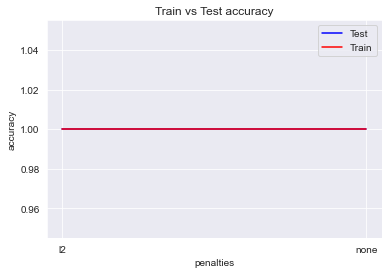

In [131]:
plt.plot(penalties, accuracy_result_test, color='b', label='Test')
plt.plot(penalties, accuracy_result_train, color='r', label='Train')
plt.title('Train vs Test accuracy')
plt.xlabel('penalties'); plt.ylabel('accuracy')
plt.legend()
plt.show()

### Масштабирование признаков

In [132]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

результат классификации: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2469
           1       1.00      1.00      1.00      1220

    accuracy                           1.00      3689
   macro avg       1.00      1.00      1.00      3689
weighted avg       1.00      1.00      1.00      3689

Матрица ошибок: 
 [[2469    0]
 [   0 1220]] 



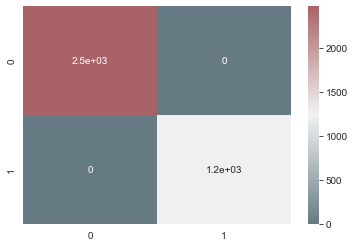

In [133]:
lr = LogisticRegression(random_state=42, solver='newton-cg')
lr.fit(X_train_scaled ,y_train)
lr_pred = lr.predict(X_test_scaled)

print_result(y_test=y_test, pred=lr_pred)

In [134]:
scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print('Средняя оценка точности: ', np.mean(scores))

Средняя оценка точности:  1.0


### Настройка гиперпараметров

In [135]:
params={"C":[*np.arange(0,1,0.01)], "penalty":["none","l2"]}
do_grid_search(model=lr,  params=params, x_train=X_train, y_train=y_train, x_test=X_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best params for accuracy
{'C': 0.0, 'penalty': 'none'}


результат классификации: 
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      2469
           1       0.00      0.00      0.00      1220

    accuracy                           0.67      3689
   macro avg       0.33      0.50      0.40      3689
weighted avg       0.45      0.67      0.54      3689

Матрица ошибок: 
 [[2469    0]
 [1220    0]] 



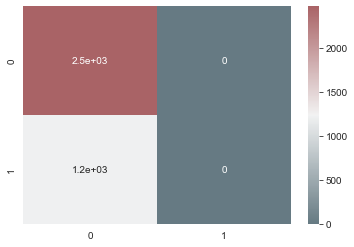

Средняя точность с настройкой гиперпараметров GridSearch:  0.7427077280650785


In [136]:
lr = LogisticRegression(C=.34,penalty="l2")
lr.fit(X_train,y_train)

print_result(y_test=y_test, pred=lr.fit(X_train, y_train).predict(X_test))
score = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print('Средняя точность с настройкой гиперпараметров GridSearch: ', np.mean(score))